In [ ]:
#  Generalized Model Training for Deforestation Detection

#  STEP 1: LOAD AND COMBINE DATA FROM MULTIPLE FOREST REGIONS

import rasterio
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib

# Update this path to your Drive folder containing the .tif files
base_path = "C:/Users/HP/Desktop/Project/EarthEngine/"
tif_files = [
    "kaziranga_deforestation.tif",
    "western_ghats_deforestation.tif",
    "sundarbans_deforestation.tif",
    "satpura_deforestation.tif",
    "corbett_deforestation.tif"
]

X_all, y_all = [], []

for tif_name in tif_files:
    path = os.path.join(base_path, tif_name)
    with rasterio.open(path) as src:
        data = src.read()

    ndvi_before = data[0]
    ndvi_after = data[1]
    ndvi_diff = data[2]
    label = data[3]

    X = np.stack([ndvi_before, ndvi_after, ndvi_diff], axis=-1).reshape(-1, 3)
    y = label.flatten()

    mask = np.all(~np.isnan(X), axis=1) & np.isin(y, [0, 1])
    X_all.append(X[mask])
    y_all.append(y[mask])

X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

print("✅ Total Features Shape:", X_all.shape)
print("✅ Total Labels Shape:", y_all.shape)

✅ Total Features Shape: (6728629, 3)
✅ Total Labels Shape: (6728629,)


In [ ]:
# ✅ STEP 2: TRAINING MULTIPLE MODELS ON GENERALIZED DATA

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


#  Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

joblib.dump(rf, "EarthEngine/RandomForest.pkl")

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("📄 Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))
print("📊 Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, y_pred_rf))

📄 Classification Report (Random Forest):
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00   1333829
         1.0       0.77      0.15      0.25     11897

    accuracy                           0.99   1345726
   macro avg       0.88      0.57      0.62   1345726
weighted avg       0.99      0.99      0.99   1345726

📊 Confusion Matrix (Random Forest):
 [[1333324     505]
 [  10159    1738]]


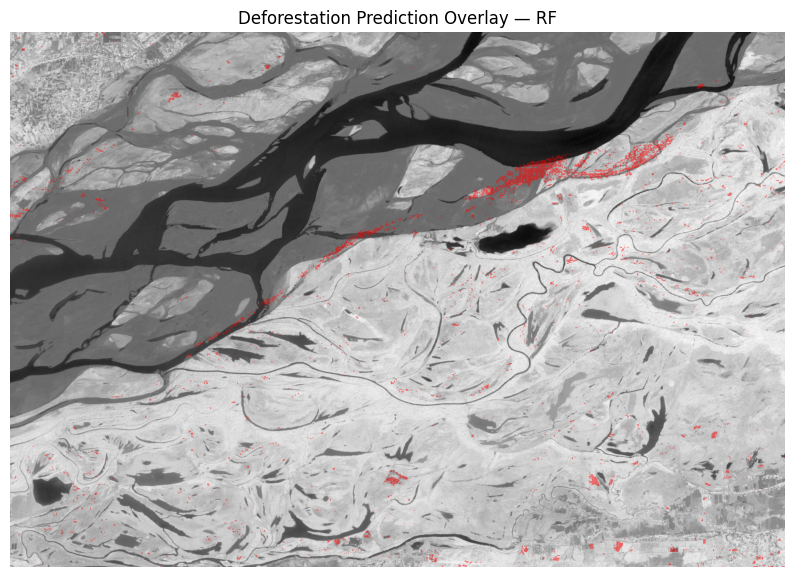

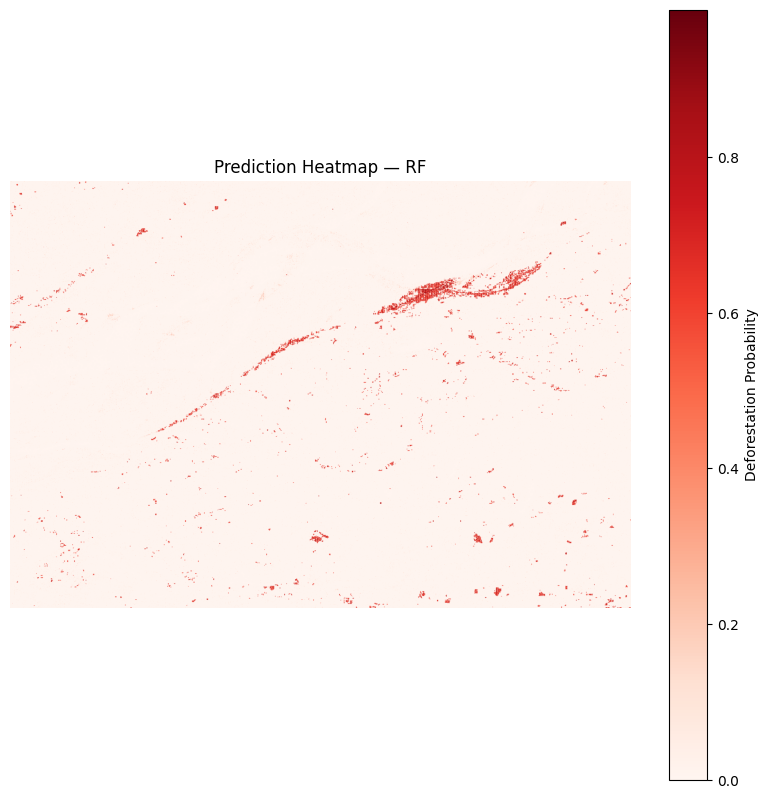

In [ ]:
#  Deforestation Visualization from Model Predictions

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import cv2

# config
TIF_PATH = "EarthEngine/kaziranga_deforestation.tif"
MODEL_PATH = "EarthEngine/RandomForest.pkl"
SCALER_PATH = "EarthEngine/StandardScaler.pkl"  # only if needed
MODEL_TYPE = "rf"  # can be 'xgboost', 'rf', 'svm', etc.

# Load .tif and model 
with rasterio.open(TIF_PATH) as src:
    data = src.read()

ndvi_before = data[0]
ndvi_after = data[1]
ndvi_diff = data[2]
true_label = data[3]

X = np.stack([ndvi_before, ndvi_after, ndvi_diff], axis=-1).reshape(-1, 3)
mask = np.all(~np.isnan(X), axis=1)

# Apply scaler if available
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    X_scaled = np.zeros_like(X)
    X_scaled[mask] = scaler.transform(X[mask])
else:
    X_scaled = X

# Load model
model = joblib.load(MODEL_PATH)
pred_flat = np.zeros(X.shape[0], dtype=np.uint8)
pred_flat[mask] = model.predict(X_scaled[mask])
pred_map = pred_flat.reshape(ndvi_before.shape)

# ========= Greyscale + Red Overlay =========
ndvi_gray = ((ndvi_before - ndvi_before.min()) / (ndvi_before.max() - ndvi_before.min()) * 255).astype(np.uint8)
rgb = np.stack([ndvi_gray] * 3, axis=-1)

overlay = np.zeros_like(rgb)
overlay[..., 0] = 255  # Red channel
alpha = np.zeros_like(pred_map, dtype=np.uint8)
alpha[pred_map == 1] = 150  # Transparent red for deforestation

blended = rgb.astype(np.float32)
for c in range(3):
    blended[..., c] = (1 - alpha / 255) * blended[..., c] + (alpha / 255) * overlay[..., c]
blended = blended.astype(np.uint8)

# ========= Display Greyscale + Red Overlay =========
plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.title(f"Deforestation Prediction Overlay — {MODEL_TYPE.upper()}")
plt.axis("off")
plt.show()

#heatmap
if hasattr(model, "predict_proba"):
    proba = np.zeros(X.shape[0])
    proba[mask] = model.predict_proba(X_scaled[mask])[:, 1]
    heatmap = proba.reshape(ndvi_before.shape)

    plt.figure(figsize=(10, 10))
    plt.imshow(heatmap, cmap="Reds")
    plt.title(f"Prediction Heatmap — {MODEL_TYPE.upper()}")
    plt.colorbar(label="Deforestation Probability")
    plt.axis("off")
    plt.show()


In [ ]:
#  Support Vector Machine
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

#  Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

#  Downsampled to 50,000 for fast training
X_sample, y_sample = resample(X_train, y_train, n_samples=50000, random_state=42)

#  Train linear SVM (without probability)
svm = SVC(kernel='linear', class_weight='balanced', probability=False)
svm.fit(X_sample, y_sample)

#  Predict & Evaluate
y_pred_svm = svm.predict(X_test)

print("📋 Classification Report (Linear SVM):")
print(classification_report(y_test, y_pred_svm))

print("📊 Confusion Matrix (Linear SVM):")
print(confusion_matrix(y_test, y_pred_svm))

#  Save model
joblib.dump(svm, "EarthEngine/SVM_linear_50k.pkl")



📋 Classification Report (Linear SVM):
              precision    recall  f1-score   support

         0.0       0.99      0.14      0.24   1333829
         1.0       0.01      0.86      0.02     11897

    accuracy                           0.14   1345726
   macro avg       0.50      0.50      0.13   1345726
weighted avg       0.98      0.14      0.24   1345726

📊 Confusion Matrix (Linear SVM):
[[ 184600 1149229]
 [   1636   10261]]


['EarthEngine/SVM_linear_50k.pkl']

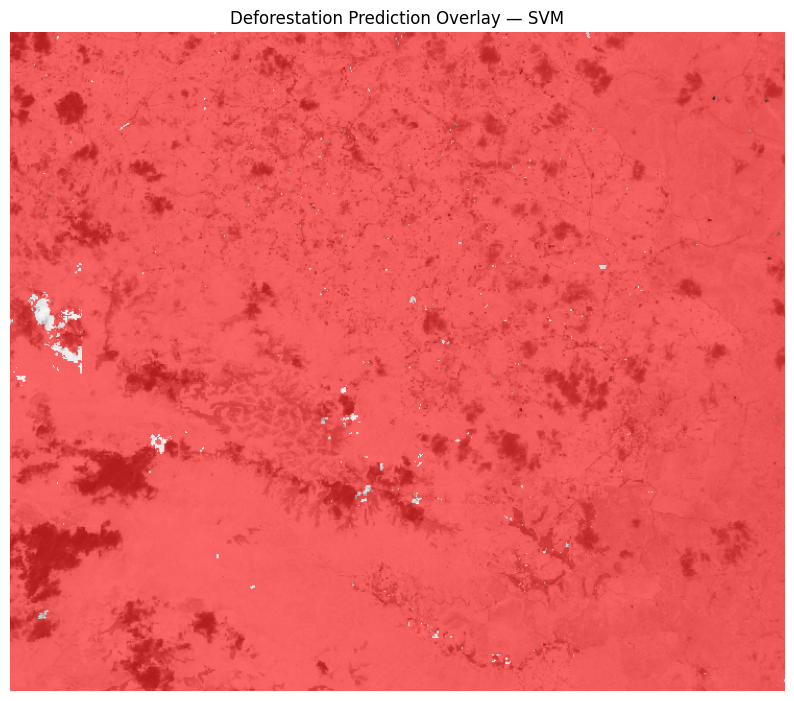

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import cv2
# ========= Config =========
TIF_PATH = "EarthEngine/western_ghats_deforestation.tif"
MODEL_PATH = "EarthEngine/SVM_linear_50k.pkl"
SCALER_PATH = "EarthEngine/StandardScaler.pkl"  # only if needed
MODEL_TYPE = "svm" 

# ========= Load .tif and model =========
with rasterio.open(TIF_PATH) as src:
    data = src.read()

ndvi_before = data[0]
ndvi_after = data[1]
ndvi_diff = data[2]
true_label = data[3]

X = np.stack([ndvi_before, ndvi_after, ndvi_diff], axis=-1).reshape(-1, 3)
mask = np.all(~np.isnan(X), axis=1)

# Apply scaler if available
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    X_scaled = np.zeros_like(X)
    X_scaled[mask] = scaler.transform(X[mask])
else:
    X_scaled = X

# Load model
model = joblib.load(MODEL_PATH)
pred_flat = np.zeros(X.shape[0], dtype=np.uint8)
pred_flat[mask] = model.predict(X_scaled[mask])
pred_map = pred_flat.reshape(ndvi_before.shape)

# ========= Greyscale + Red Overlay =========
ndvi_gray = ((ndvi_before - ndvi_before.min()) / (ndvi_before.max() - ndvi_before.min()) * 255).astype(np.uint8)
rgb = np.stack([ndvi_gray] * 3, axis=-1)

overlay = np.zeros_like(rgb)
overlay[..., 0] = 255  # Red channel
alpha = np.zeros_like(pred_map, dtype=np.uint8)
alpha[pred_map == 1] = 150  # Transparent red for deforestation

blended = rgb.astype(np.float32)
for c in range(3):
    blended[..., c] = (1 - alpha / 255) * blended[..., c] + (alpha / 255) * overlay[..., c]
blended = blended.astype(np.uint8)

# ========= Display Greyscale + Red Overlay =========
plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.title(f"Deforestation Prediction Overlay — {MODEL_TYPE.upper()}")
plt.axis("off")
plt.show()

# ========= Optional: Heatmap =========
# Only if model supports predict_proba()
if hasattr(model, "predict_proba"):
    proba = np.zeros(X.shape[0])
    proba[mask] = model.predict_proba(X_scaled[mask])[:, 1]
    heatmap = proba.reshape(ndvi_before.shape)

    plt.figure(figsize=(10, 10))
    plt.imshow(heatmap, cmap="Reds")
    plt.title(f"Prediction Heatmap — {MODEL_TYPE.upper()}")
    plt.colorbar(label="Deforestation Probability")
    plt.axis("off")
    plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# 🎯 Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

joblib.dump(lr, "EarthEngine/LogisticRegression.pkl")

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
print("📄 Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))
print("📊 Confusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_lr))
    

📄 Classification Report (Logistic Regression):
               precision    recall  f1-score   support

         0.0       0.99      0.60      0.75   1333829
         1.0       0.01      0.50      0.02     11897

    accuracy                           0.60   1345726
   macro avg       0.50      0.55      0.39   1345726
weighted avg       0.98      0.60      0.74   1345726

📊 Confusion Matrix (Logistic Regression):
 [[802265 531564]
 [  5902   5995]]


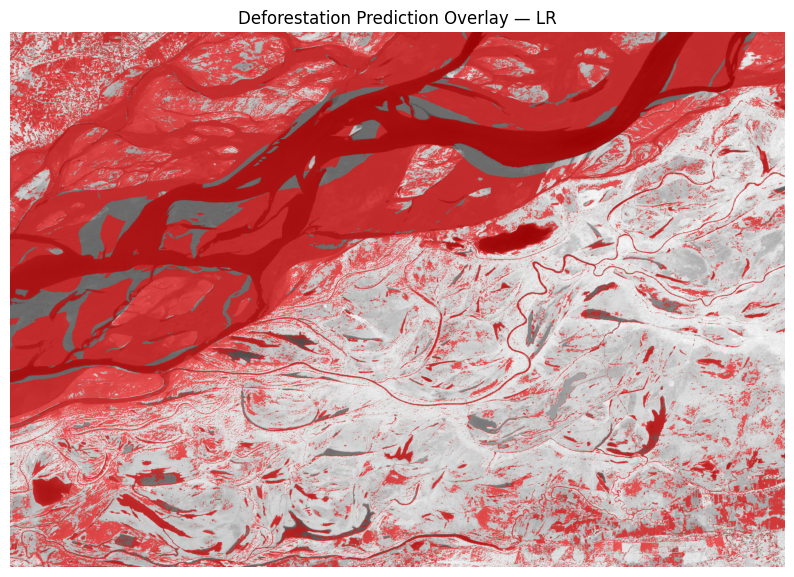

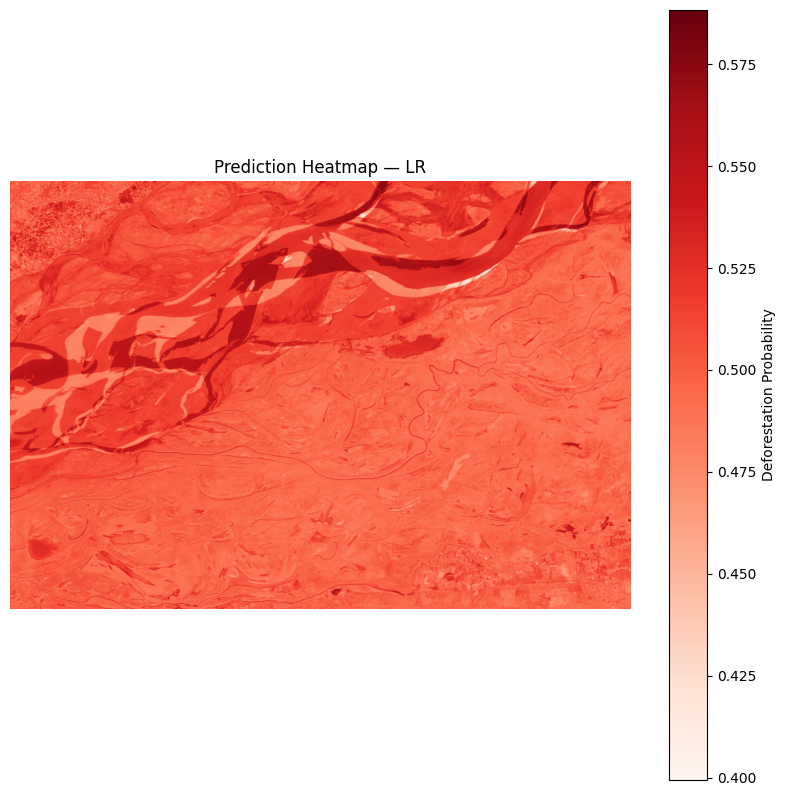

In [7]:
# 📦 Deforestation Visualization from Model Predictions

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import cv2

# ========= Config =========
TIF_PATH = "EarthEngine/kaziranga_deforestation.tif"
MODEL_PATH = "EarthEngine/LogisticRegression.pkl"
SCALER_PATH = "EarthEngine/StandardScaler.pkl"  # only if needed
MODEL_TYPE = "lr"  # can be 'xgboost', 'rf', 'svm', etc.

# ========= Load .tif and model =========
with rasterio.open(TIF_PATH) as src:
    data = src.read()

ndvi_before = data[0]
ndvi_after = data[1]
ndvi_diff = data[2]
true_label = data[3]

X = np.stack([ndvi_before, ndvi_after, ndvi_diff], axis=-1).reshape(-1, 3)
mask = np.all(~np.isnan(X), axis=1)

# Apply scaler if available
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    X_scaled = np.zeros_like(X)
    X_scaled[mask] = scaler.transform(X[mask])
else:
    X_scaled = X

# Load model
model = joblib.load(MODEL_PATH)
pred_flat = np.zeros(X.shape[0], dtype=np.uint8)
pred_flat[mask] = model.predict(X_scaled[mask])
pred_map = pred_flat.reshape(ndvi_before.shape)

# ========= Greyscale + Red Overlay =========
ndvi_gray = ((ndvi_before - ndvi_before.min()) / (ndvi_before.max() - ndvi_before.min()) * 255).astype(np.uint8)
rgb = np.stack([ndvi_gray] * 3, axis=-1)

overlay = np.zeros_like(rgb)
overlay[..., 0] = 255  # Red channel
alpha = np.zeros_like(pred_map, dtype=np.uint8)
alpha[pred_map == 1] = 150  # Transparent red for deforestation

blended = rgb.astype(np.float32)
for c in range(3):
    blended[..., c] = (1 - alpha / 255) * blended[..., c] + (alpha / 255) * overlay[..., c]
blended = blended.astype(np.uint8)

# ========= Display Greyscale + Red Overlay =========
plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.title(f"Deforestation Prediction Overlay — {MODEL_TYPE.upper()}")
plt.axis("off")
plt.show()

# ========= Optional: Heatmap =========
# Only if model supports predict_proba()
if hasattr(model, "predict_proba"):
    proba = np.zeros(X.shape[0])
    proba[mask] = model.predict_proba(X_scaled[mask])[:, 1]
    heatmap = proba.reshape(ndvi_before.shape)

    plt.figure(figsize=(10, 10))
    plt.imshow(heatmap, cmap="Reds")
    plt.title(f"Prediction Heatmap — {MODEL_TYPE.upper()}")
    plt.colorbar(label="Deforestation Probability")
    plt.axis("off")
    plt.show()

In [ ]:

# Count class distribution
n_0 = np.sum(y_train == 0)
n_1 = np.sum(y_train == 1)
scale_pos_weight = n_0 / n_1

# Best-balanced XGBoost setup
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=1
)
# Train
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluation
print("📋 Classification Report (Optimized XGBoost):")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix (Optimized XGBoost):")
print(confusion_matrix(y_test, y_pred))

# Save
joblib.dump(xgb, "EarthEngine/XGBoost.pkl")



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [04:13:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📋 Classification Report (Optimized XGBoost):
              precision    recall  f1-score   support

         0.0       1.00      0.63      0.77   1333829
         1.0       0.02      0.67      0.03     11897

    accuracy                           0.63   1345726
   macro avg       0.51      0.65      0.40   1345726
weighted avg       0.99      0.63      0.77   1345726

🧾 Confusion Matrix (Optimized XGBoost):
[[841498 492331]
 [  3885   8012]]


['EarthEngine/XGBoost.pkl']

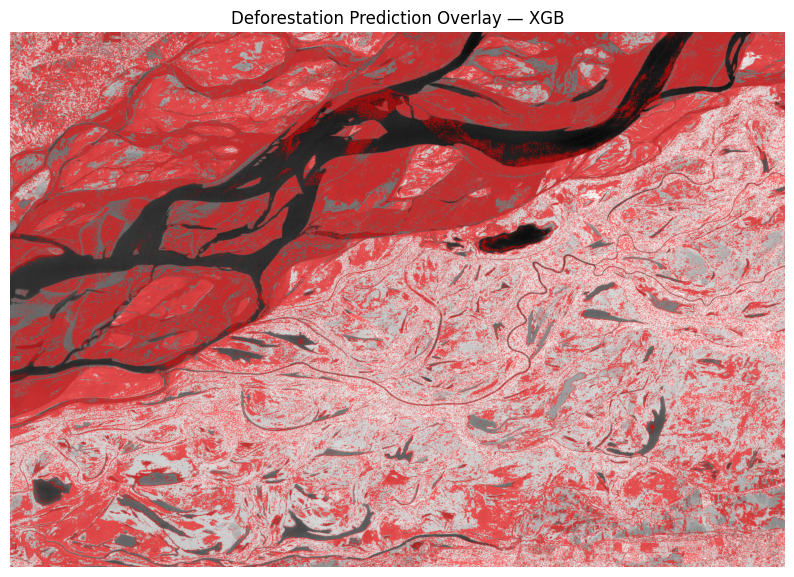

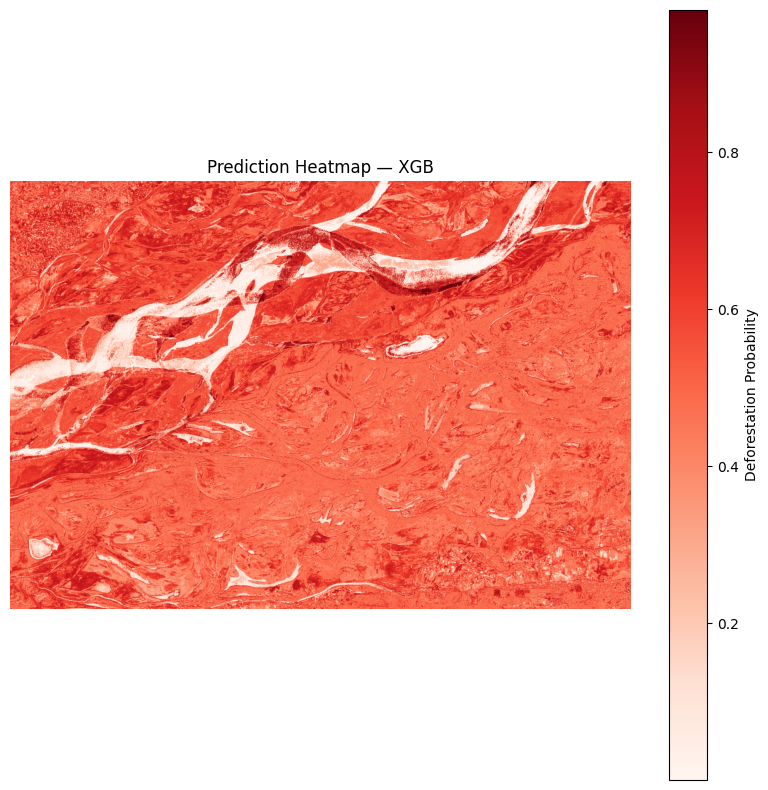

In [8]:
# 📦 Deforestation Visualization from Model Predictions

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import cv2

# ========= Config =========
TIF_PATH = "EarthEngine/kaziranga_deforestation.tif"
MODEL_PATH = "EarthEngine/XGBoost.pkl"
SCALER_PATH = "EarthEngine/StandardScaler.pkl"  # only if needed
MODEL_TYPE = "xgb"  # can be 'xgboost', 'rf', 'svm', etc.

# ========= Load .tif and model =========
with rasterio.open(TIF_PATH) as src:
    data = src.read()

ndvi_before = data[0]
ndvi_after = data[1]
ndvi_diff = data[2]
true_label = data[3]

X = np.stack([ndvi_before, ndvi_after, ndvi_diff], axis=-1).reshape(-1, 3)
mask = np.all(~np.isnan(X), axis=1)

# Apply scaler if available
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    X_scaled = np.zeros_like(X)
    X_scaled[mask] = scaler.transform(X[mask])
else:
    X_scaled = X

# Load model
model = joblib.load(MODEL_PATH)
pred_flat = np.zeros(X.shape[0], dtype=np.uint8)
pred_flat[mask] = model.predict(X_scaled[mask])
pred_map = pred_flat.reshape(ndvi_before.shape)

# ========= Greyscale + Red Overlay =========
ndvi_gray = ((ndvi_before - ndvi_before.min()) / (ndvi_before.max() - ndvi_before.min()) * 255).astype(np.uint8)
rgb = np.stack([ndvi_gray] * 3, axis=-1)

overlay = np.zeros_like(rgb)
overlay[..., 0] = 255  # Red channel
alpha = np.zeros_like(pred_map, dtype=np.uint8)
alpha[pred_map == 1] = 150  # Transparent red for deforestation

blended = rgb.astype(np.float32)
for c in range(3):
    blended[..., c] = (1 - alpha / 255) * blended[..., c] + (alpha / 255) * overlay[..., c]
blended = blended.astype(np.uint8)

# ========= Display Greyscale + Red Overlay =========
plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.title(f"Deforestation Prediction Overlay — {MODEL_TYPE.upper()}")
plt.axis("off")
plt.show()

# ========= Optional: Heatmap =========
# Only if model supports predict_proba()
if hasattr(model, "predict_proba"):
    proba = np.zeros(X.shape[0])
    proba[mask] = model.predict_proba(X_scaled[mask])[:, 1]
    heatmap = proba.reshape(ndvi_before.shape)

    plt.figure(figsize=(10, 10))
    plt.imshow(heatmap, cmap="Reds")
    plt.title(f"Prediction Heatmap — {MODEL_TYPE.upper()}")
    plt.colorbar(label="Deforestation Probability")
    plt.axis("off")
    plt.show()

In [11]:
models = {
    "RandomForest": joblib.load("EarthEngine/RandomForest.pkl"),
    "SVM": joblib.load("EarthEngine/SVM_linear_50k.pkl"),
    "XGBoost": joblib.load("EarthEngine/XGBoost.pkl"),
    "LogisticRegression": joblib.load("EarthEngine/LogisticRegression.pkl")
}

# Save combined model dictionary
joblib.dump(models, "EarthEngine/all_classical_models.pkl")


['EarthEngine/all_classical_models.pkl']